# Adjusting the library's code to my needs

I needed to edit the preprocessing script of the data module to preprocess at least 10 taxis, as it was designed to give as trajectory df only the records of one taxi. It is not a permanent solution, but just a quick fix as I don't know the intention behind the choice of one taxi only

In [1]:
path_to_file_to_edit = 'C:\\Users\\Ludovico\\anaconda3\\envs\\Geo\\Lib\\site-packages\\skmob\\data\\datasets\\taxi_san_francisco\\taxi_san_francisco.py'

f = open(path_to_file_to_edit, 'w')

f.write("""\
import pandas
import skmob
from datetime import timedelta
from datetime import datetime
from skmob.data.load import DatasetBuilder


'''
*** Scikit-Mobility Pre-Processing dataset script (DPS) ***

'''


class taxi_san_francisco(DatasetBuilder):
    
    # The constructor of the parent class (DatasetBuilder) is called
    # automatically, so the explicit call can be omitted
    
    '''
    `prepare(self, f_names)`.
    Assume that the paths of the files downloaded at the URL specified in the JSON file 
    are described by the argument `f_names` (represented as a list of strings) then:
        1. load the dataset
        2. pre-process it if necessary (e.g., adjust the timezone or delete/add something)
        3. convert it in the correct skmob format:
            trajectory -> TrajDataFrame
            flow -> FlowDataFrame
            shape -> GeoDataFrame
            auxiliar -> DataFrame
        4. return the dataset in the skmob format
    '''
    
    ### I EDITED FROM HERE, I HAD TO LOOP ACROSS THE FILES TO LOAD THE SINGLE CSV, THEN CONCATENATE IT TO THE MAIN ###
    def prepare(self, f_names):

        full_raw = pandas.DataFrame(columns=['latitude', 'longitude', 'occupancy', 'time', 'user_id'])

        for n, fs in enumerate(f_names):
        
            # to convert the datetime from UNIX to UTC
            mydateparser = lambda x: pandas.to_datetime(x, unit='s') + timedelta(minutes=-7*60)
        
        
            #read data
            raw_data = pandas.read_csv(fs, sep=self.dataset_info['sep'], 
                                       encoding=self.dataset_info['encoding'],
                                       names=['latitude', 'longitude', 'occupancy', 'time'],
                                       parse_dates=['time'], date_parser=mydateparser,
                                       header=None)
            
            #add the ID as a column
            raw_data['user_id'] = [fs[fs.rfind('_')+1:fs.rfind('.')]]*len(raw_data)

            full_raw = pandas.concat((full_raw, raw_data), ignore_index = True)
            
            if n == 9:
                break
        
        # convert the datetime
        tdf_dataset = skmob.TrajDataFrame(full_raw, latitude='latitude', 
                                          longitude='longitude', 
                                          user_id='user_id', 
                                          datetime='time')
        

        return tdf_dataset
""")
f.close()

# Homework 4.1
How fast are users?
Choose one of the datasets seen at lesson (taxis, Geolife, etc.), select
at least 10 users/vehicles and compute distributions of lengths.
Remove 10% of points in each trajectory and repeat the distribution.
Do the same for 20%, 30%, ... 90%. How does length distribution
change?
* Submit a (well commented) python notebook

## Importing Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import math

import skmob
from skmob.utils.plot import plot_gdf
import folium
import random

import urllib.request
import requests

import osmnx as ox
from shapely.geometry import *

#to compress the trajectory
from skmob.preprocessing.compression import compress

#data module
from skmob.data.load import load_dataset, list_datasets

In [3]:
#looking at the name of the datasets
list_datasets()

['flow_foursquare_nyc',
 'foursquare_nyc',
 'nyc_boundaries',
 'parking_san_francisco',
 'taxi_san_francisco']

## Downloading and preprocessing the Dataset
I put the credentials into a text file in the same folder, I loaded them here into a variable

In [4]:
#loading my credentials for the dataset website
with open('credentials.txt', 'r') as f:
    credentials = tuple([x.rstrip('\n') for x in f.readlines()])

In [5]:
#I had to manually correct the SSL certificate error, I made a pull request about it
tdf = load_dataset('taxi_san_francisco', auth=credentials, show_progress=True)

C:\Users\Ludovico\anaconda3\envs\Geo\lib\site-packages\skmob\data\load.py:167: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset._info = dataset_info


This is how the dataset looks

In [6]:
tdf.head()

,lat,lng,occupancy,datetime,uid
0,37.75134,-122.39488,0,2008-06-10 00:58:07,abboip
1,37.75136,-122.39527,0,2008-06-10 00:57:39,abboip
2,37.75199,-122.39460,0,2008-06-10 00:55:40,abboip
3,37.75080,-122.39346,0,2008-06-10 00:54:49,abboip
4,37.75015,-122.39256,0,2008-06-10 00:50:37,abboip


The occupancy should be either 0 or 1

In [7]:
tdf['occupancy'].unique()

array([0, 1], dtype=object)

**The number of unique taxies in the tdf should be 10 as I specified in the preoprocessing .py file**

In [8]:
n_taxi = len(tdf['uid'].unique())
n_taxi

10

In [9]:
tdf['uid'].unique()

array(['abboip', 'abcoij', 'abdremlu', 'abgibo', 'abjoolaw', 'abmuyawm',
       'abniar', 'abnovkak', 'abtyff', 'abwecnij'], dtype=object)

## Visualizing a trajectory of a single taxi

In [ ]:
tdf.plot_trajectory(start_end_markers=False, max_users=1, max_points=None)

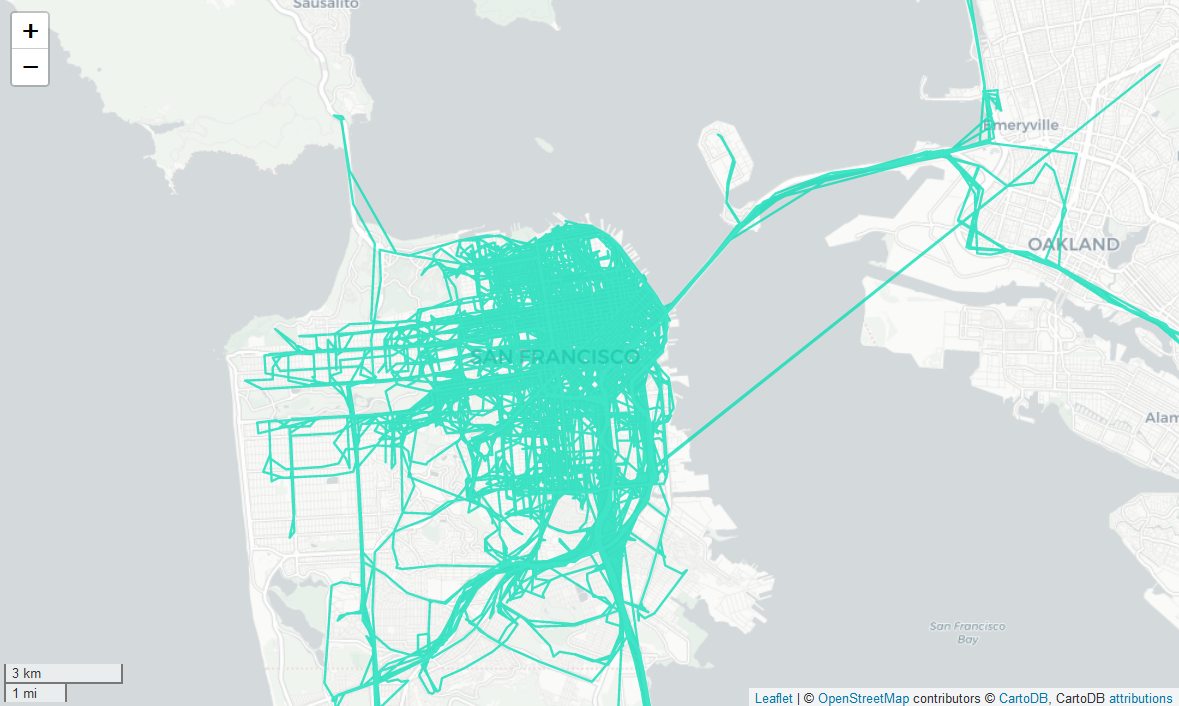

## Computing the distributions of lengths

I first import the haversine function I wrote

In [11]:
from math import cos, sin, asin, sqrt, pi

def to_radians(*args): #I needed radians to work with trigonometry
    for raw in args:
        yield raw*(pi/180) #I made it a generator out of convenience

assert round(next(to_radians(1)), 5) == 0.01745, "It's not equal to the proper conversion of degree to radians"

def haversine_formula(latP, lonP, latQ, lonQ):
    #converting the latitude and longitudes to radians
    latP, lonP, latQ, lonQ = tuple(to_radians(latP, lonP, latQ, lonQ))
    #print(latP, lonP, latQ, lonQ)

    earth_radius = 6371 #km, from wikipedia

    Dlat = latQ - latP
    Dlon = lonQ - lonP

    #I copied and translated the formula to python
    to_sqrt = sin(Dlat/2)**2 + cos(latP)*cos(latQ)*sin(Dlon/2)**2
    d = 2*earth_radius*asin(sqrt(to_sqrt))

    return  d

I first write a function to extract each user from the trajectory dataframe, sort by ascending datetime and dropping the original indexes of the unsorted df

In [12]:
def user_tdf(tdf, uid):
    single_user = tdf[tdf['uid'] == uid] #extract tdf of a user
    sorted_tdf = single_user.sort_values(by='datetime', ascending = True) #sort by datetime
    return sorted_tdf.reset_index(drop=True) #drop original indexes

single_taxi = user_tdf(tdf, 'abboip')
single_taxi.head()

,lat,lng,occupancy,datetime,uid
0,37.75153,-122.39447,0,2008-05-17 07:12:10,abboip
1,37.75149,-122.39447,0,2008-05-17 07:13:34,abboip
2,37.75149,-122.39447,0,2008-05-17 07:14:34,abboip
3,37.75149,-122.39446,0,2008-05-17 07:15:35,abboip
4,37.75144,-122.39449,0,2008-05-17 07:41:43,abboip


Then to compute the distances between each point I select a taxi, then I loop across all the rows of the tdf and compute the earth distance between each point and its previous point in the trajectory.
</br></br>
In the case of the first row of the dataframe I usede infinity to avoid trimming it in later computations (I will remove points with a distance inferior than certain thresholds later, and 0 would be removed as always lower than such thresholds)

In [13]:
def get_point_dists(tdf):
    
    distances = list() #creating the list to output
    
    #loop across all rows
    for _, row in tdf.iterrows():
        try:
            #if it is not the first row of the df compute the earth distance and append it
            computed_distance = haversine_formula(row['lat'], row['lng'], 
                                                  stored_lat, stored_lon)
            distances.append(computed_distance)
            stored_lat, stored_lon = row['lat'], row['lng'] #store current lat and lon
            
        except NameError: #because stored_lat and lon are still to be defined
            #if it is the first row there is no predecessor so I input 0 distance
            distances.append(np.inf)
            stored_lat, stored_lon = row['lat'], row['lng'] #store current lat and lon
            
    return np.array(distances)

distances = get_point_dists(single_taxi)

In [14]:
distances[:10]

array([       inf, 0.0044478 , 0.        , 0.00087919, 0.00615366,
       0.00854124, 0.04580668, 0.00416093, 0.00286238, 0.00087919])

Adding the distances to the tdf of the taxi

In [15]:
single_taxi['from_prev_dist'] = distances

## Computing the first decile of the distributions

In order to remove points I decided first to remove points with the lower distances from their predecessors according to thresholds in the quantile distributions... It would obviously result in an increase of the average distance as the points closer to each other would be trimmed.
</br>
To remove the first 10% of points thus I remove first the lower decile of the distribution as in the following example

In [16]:
decile = np.quantile(distances, 0.1)
reduced_tdf = single_taxi[single_taxi["from_prev_dist"] > decile]

print(f"""Removing points with an with a lower distance than {decile:.2f} meters, I have {len(reduced_tdf)} points left""")

Removing points with an with a lower distance than 0.00 meters, I have 21145 points left


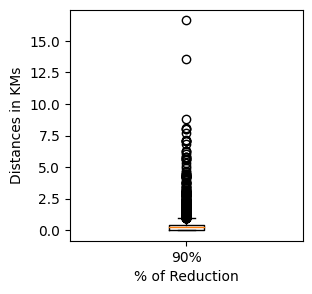

In [17]:
plt.figure(figsize=(3,3))
plt.boxplot(reduced_tdf['from_prev_dist'].values)
plt.xticks([1], ['90%'])
plt.xlabel('% of Reduction')
plt.ylabel('Distances in KMs')
plt.show()

## Testing the structure of the final plot
Here I just tested and set the grid of plots

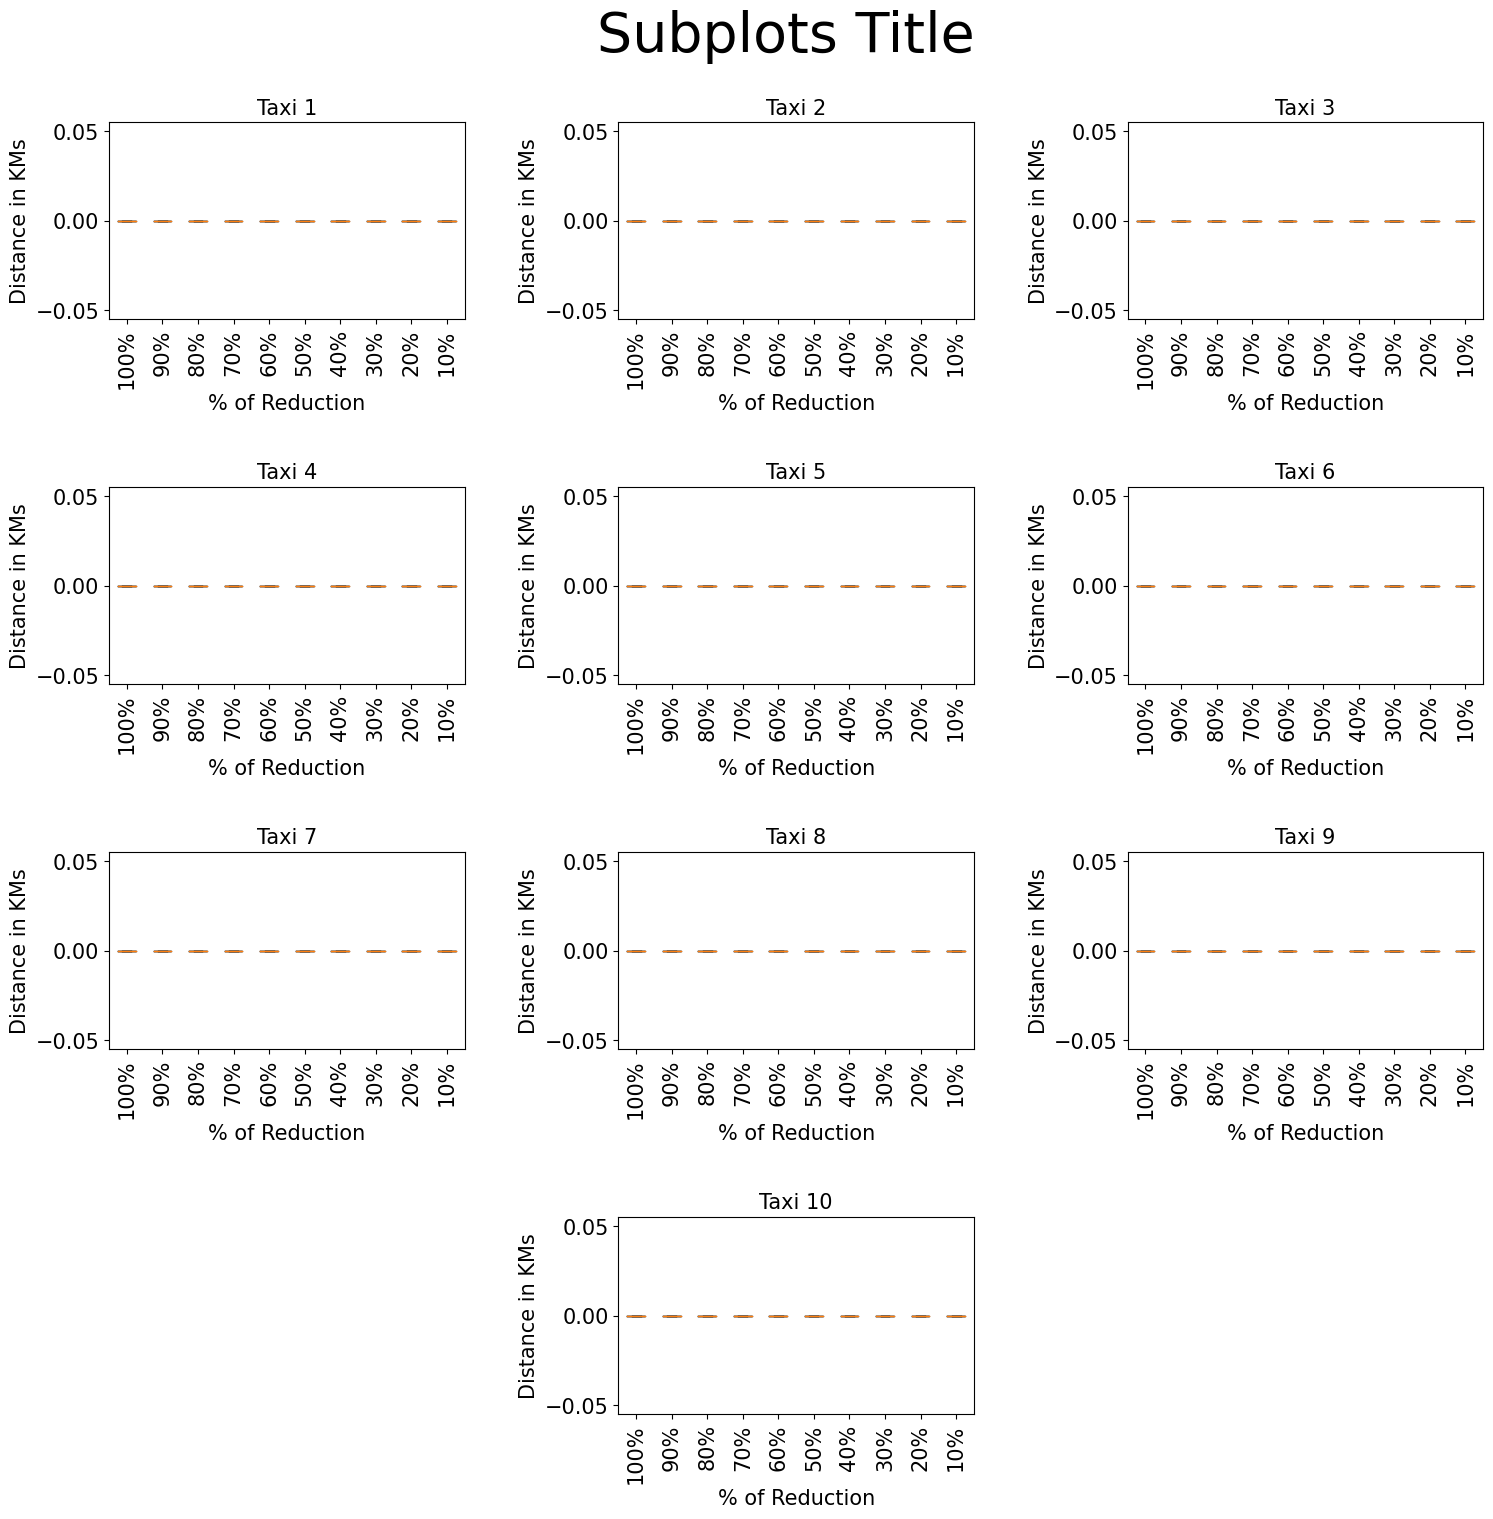

In [18]:
plt_is, plt_columns = 4, 3
fig, axs = plt.subplots(plt_is, plt_columns, figsize = (15,15))
plt.suptitle('Subplots Title', fontsize=40)
fig.tight_layout(w_pad=8.0, h_pad=10.0, pad = 3.0)

for i in range(10):
    row_p = i // plt_columns #increases by 1 the i only once I have reached the last column
    
    #I set the current column, increasing it at each iteration but resetting once surpassed the max number of columns
    col_p = i - plt_columns * row_p #I have to reduce by a factor of the current row as the value of i is increases
    adjust_last = 1 if i == 9 else 0 #in order to adjust the last plot to the center

    current_ax = axs[row_p][col_p + adjust_last] #I add 1 if in the last iteration to center the subplot

    current_ax.boxplot([[0]]*10) #testing on a distribution of zeroes
    
    #setting the ticks as the reducing percentages
    current_ax.set_xticks(np.arange(1, 11), 
                                    [str(x)+'%' for x in range(100, 9, -10)], 
                                    fontsize=15,
                                    rotation=90)
    
    current_ax.yaxis.set_tick_params(labelsize=15)
    current_ax.set_title(f'Taxi {i+1}', fontsize=15)
    current_ax.set_xlabel(f'% of Reduction', fontsize=15)
    current_ax.set_ylabel(f'Distance in KMs', fontsize=15) 

#I am in the last row now, I remove the first and last columns of the subplot to leave only the one in the center
fig.delaxes(axs[row_p][col_p])
fig.delaxes(axs[row_p][col_p+2])
plt.show()

## Computing the length distribution by taxi and % reduction

I will first compute it according to the logic of compressing the trajectory

Getting the Taxis' ID

In [19]:
taxi_names = tdf['uid'].unique()
taxi_names

array(['abboip', 'abcoij', 'abdremlu', 'abgibo', 'abjoolaw', 'abmuyawm',
       'abniar', 'abnovkak', 'abtyff', 'abwecnij'], dtype=object)

Defining a Function to reduce the trajectory dataframe according to the distances available and the decile and a message function to print some info to understand the processing of the iteration

In [20]:
def reduce_tdf(tdf, distances, decile):
    return single_taxi.loc[np.where(distances > decile)].reset_index(drop=True)
def message_info(tdf, decile = 0, ratio = 1): #if decile and ratio are not specified they are 0.0 and 100%
    print(f'Removing points with a lower distance than {decile*1000:.2f} meters,')
    print(f'I have {len(tdf)} points left, which is {ratio:.2%} of the original distribution')
    return

**As it can be seen, as expected, the distribution of distances moves the distances up a little after each reduction of points with the closer distance, but the effect is not that great with many points left**
</br>
</br>
NB: The distances are recomputed at each iteration so the reduction is not based on the original distances of the points. The only thing considered of the original distribution is the number of records, indeed I remove always a 10% of the original distribution but according to the new distances, at each iteration I remove slightly more points with respect to the ratio of number of points removed from the previous iteration

_________________________________
Removing points with a lower distance than 0.00 meters,
I have 23495 points left, which is 100.00% of the original distribution
Removing points with a lower distance than 1.42 meters,
I have 21145 points left, which is 90.00% of the original distribution
Removing points with a lower distance than 4.78 meters,
I have 18795 points left, which is 80.00% of the original distribution
Removing points with a lower distance than 33.53 meters,
I have 16445 points left, which is 69.99% of the original distribution
Removing points with a lower distance than 124.94 meters,
I have 14095 points left, which is 59.99% of the original distribution
Removing points with a lower distance than 203.06 meters,
I have 11745 points left, which is 49.99% of the original distribution
Removing points with a lower distance than 290.55 meters,
I have 9396 points left, which is 39.99% of the original distribution
Removing points with a lower distance than 400.47 meters,
I have 7047 

Removing points with a lower distance than 85.65 meters,
I have 17866 points left, which is 69.99% of the original distribution
Removing points with a lower distance than 173.79 meters,
I have 15313 points left, which is 59.99% of the original distribution
Removing points with a lower distance than 253.45 meters,
I have 12760 points left, which is 49.99% of the original distribution
Removing points with a lower distance than 350.80 meters,
I have 10208 points left, which is 39.99% of the original distribution
Removing points with a lower distance than 489.34 meters,
I have 7656 points left, which is 29.99% of the original distribution
Removing points with a lower distance than 732.92 meters,
I have 5104 points left, which is 20.00% of the original distribution
Removing points with a lower distance than 1433.23 meters,
I have 2552 points left, which is 10.00% of the original distribution
_________________________________
Removing points with a lower distance than 0.00 meters,
I have 241

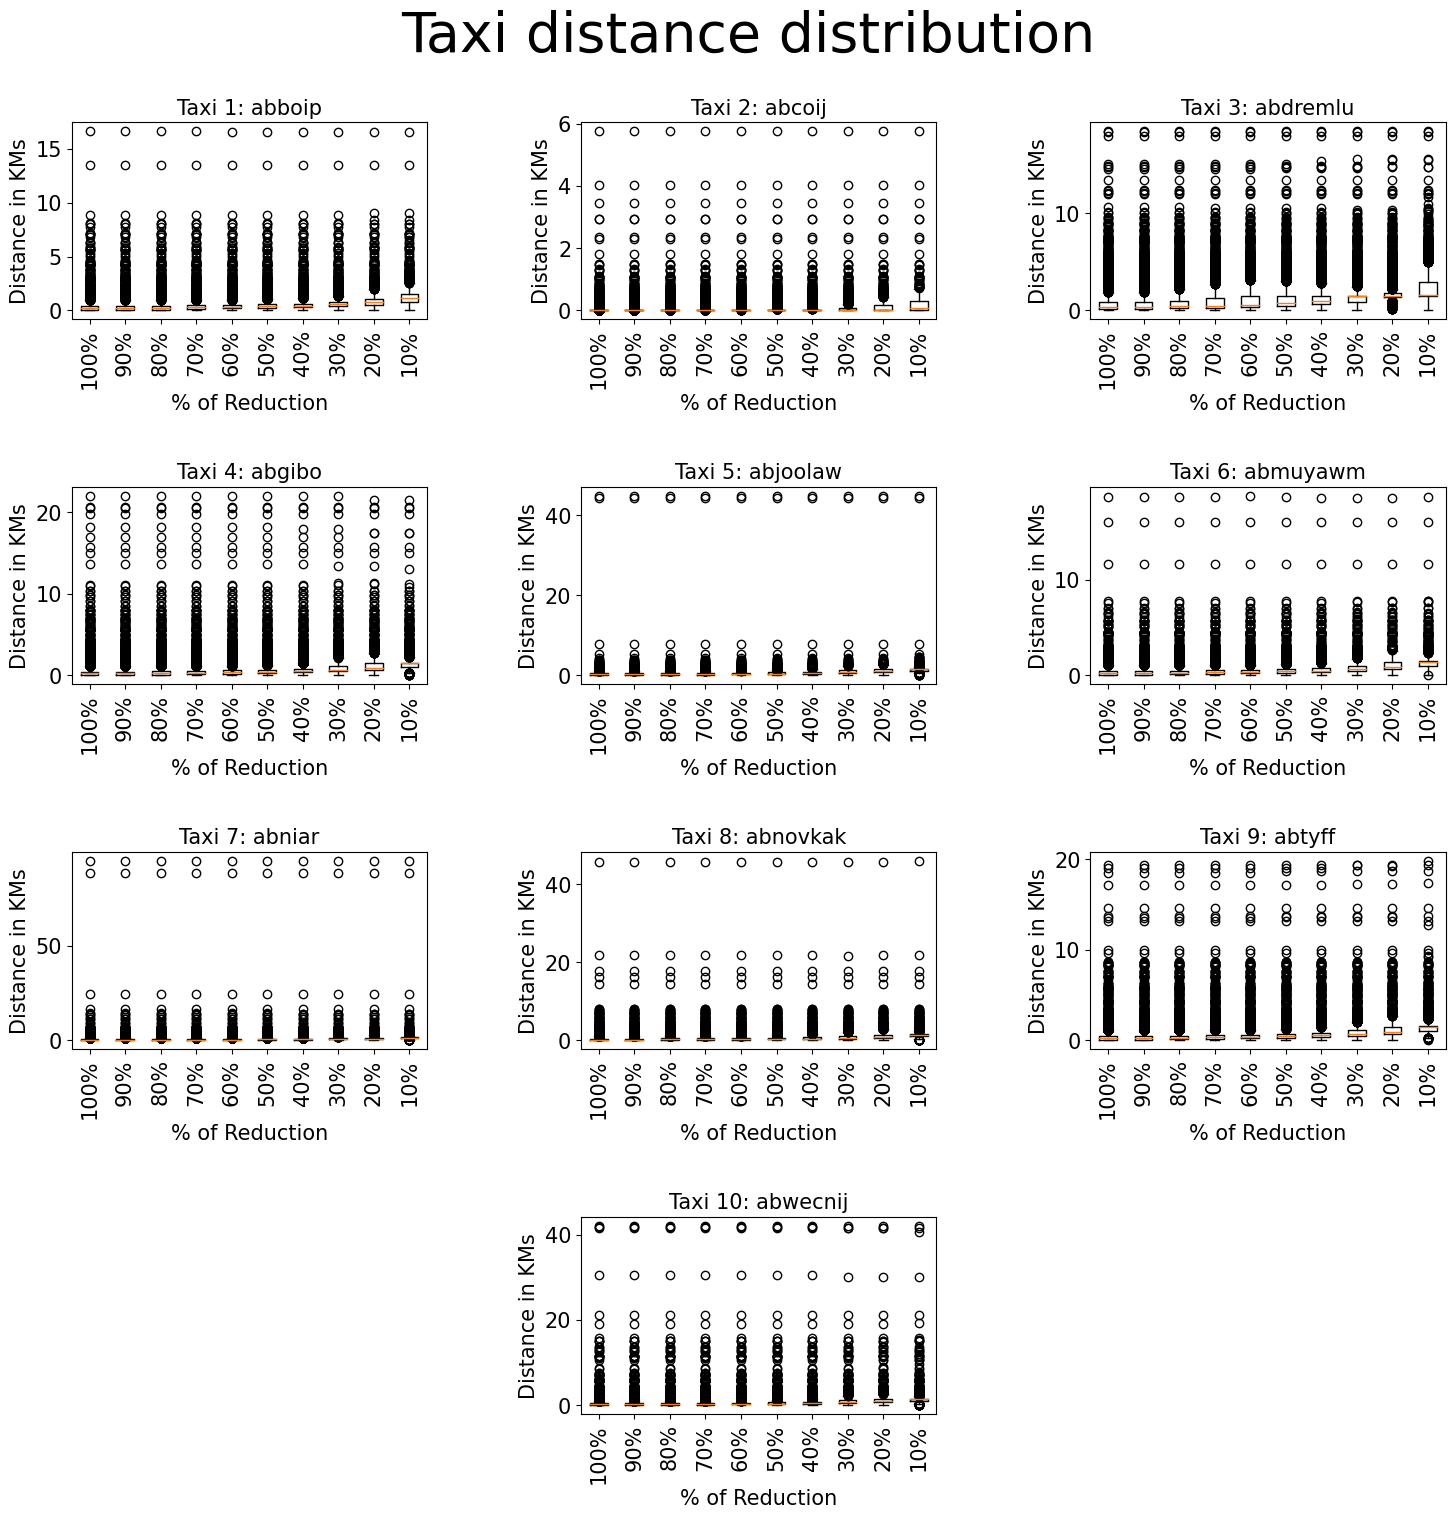

In [21]:
plt_rows, plt_columns = 4, 3 #setting 4 rows and 3 columns
fig, axs = plt.subplots(plt_rows, plt_columns, figsize = (15,15)) #creating the subplot grid
plt.suptitle('Taxi distance distribution', fontsize=40) #giving a title to the plot
fig.tight_layout(w_pad=8.0, h_pad=10.0, pad = 3.0) #adjusting the distances between plots

#arithmetic progression of percentiles to consider for each reduction
#I did it to reduce exactly the trajectory dataframe always by 10% of the original distribution
#otherwise the reduction of records would also reduce at each iteration

percentiles = [(x / (x-10)) for x in range(110, 10, -10)]

save_distances = dict()

for i, taxi in enumerate(taxi_names):
    print('_________________________________')
    
    single_taxi = user_tdf(tdf, taxi) #setting the tdf
    original_length = len(single_taxi) #storing the original length for computing the ratio later
    taxi_dist = [get_point_dists(single_taxi)] #adding the original distances to a new list
    
    message_info(single_taxi) #printing the metadata of the original distribution

    for reduction_n in range(9):
        distances = get_point_dists(single_taxi)
        taxi_dist.append(distances)
        
        #computing the percentile to consider at this iteration
        percentile = percentiles[reduction_n] - 1
        
        #getting the next decile of the original distribution with the new distances
        decile = np.quantile(distances, percentile) 
        
        #reducing the records of the tdf according to the new distances and decile
        single_taxi = reduce_tdf(single_taxi, distances, decile)
        
        #getting the ratio of the reduced tdf according to the original length of the tdf
        ratio = len(single_taxi) / original_length
        message_info(single_taxi, decile, ratio) #printing the metadata
        
    #saving the distribution of length of each taxi into a dictionary
    save_distances[taxi] = taxi_dist
    
    #### PLOT SETTINGS SHOWN BEFORE ####
    row_p = i // plt_columns
    col_p = i - plt_columns * row_p
    adjust_last = 1 if i == 9 else 0 

    current_ax = axs[row_p][col_p + adjust_last]
    
    current_ax.boxplot(taxi_dist)
    current_ax.set_xticks(np.arange(1, 11), 
                                    [str(x)+'%' for x in range(100, 9, -10)], 
                                    fontsize=15,
                                    rotation=90)

    current_ax.yaxis.set_tick_params(labelsize=15)
    current_ax.set_title(f'Taxi {i+1}: {taxi}', fontsize=15)
    current_ax.set_xlabel(f'% of Reduction', fontsize=15)
    current_ax.set_ylabel(f'Distance in KMs', fontsize=15)
    
#I am in the last row now, I remove the first and last columns of the subplot to leave only the one in the center
fig.delaxes(axs[row_p][col_p])
fig.delaxes(axs[row_p][col_p+2])
plt.show()

**The observation was confirmed by looking at the average increases after each reduction for each taxi**

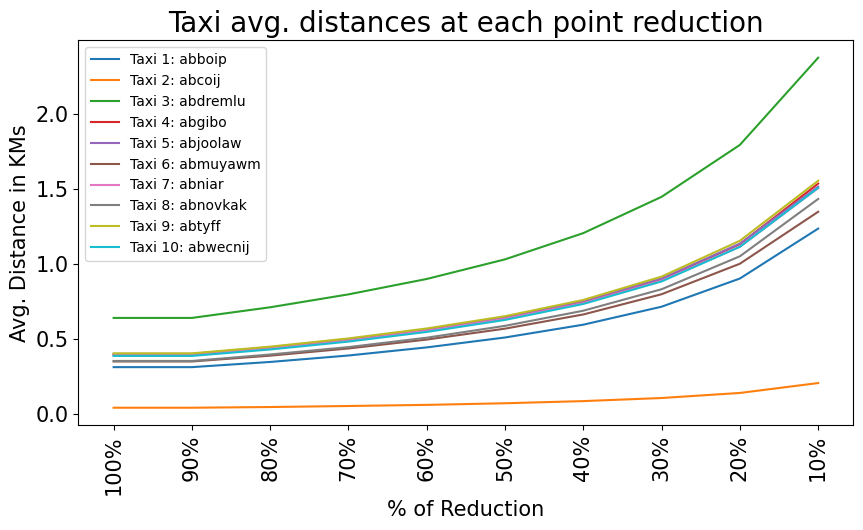

In [22]:
plt.figure(figsize = (10,5)) #creating the subplot grid

for i, taxi in enumerate(taxi_names):
    
    averages = list()
    dist_list = save_distances[taxi]
    
    for dist_array in dist_list:
        #computing the average of all distance arrays besides the infinity (the first elements of each distance array)
        averages.append(np.average(dist_array[1:])) 
    
    plt.plot(averages, label = f'Taxi {i+1}: {taxi}')
    
plt.title('Taxi avg. distances at each point reduction', fontsize=20)
plt.xticks(np.arange(0, 10), 
           [str(x)+'%' for x in range(100, 9, -10)], 
           fontsize=15, rotation=90)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(f'% of Reduction', fontsize=15)
plt.ylabel(f'Avg. Distance in KMs', fontsize=15)
plt.legend()
plt.show()

**The length of the Trajectories after each reduction of points according to the removal of lower decile of the distances causes a slow decrease of the length of the trajectory, probably because point closer to each other are visited skipping  even closer intermediate points**

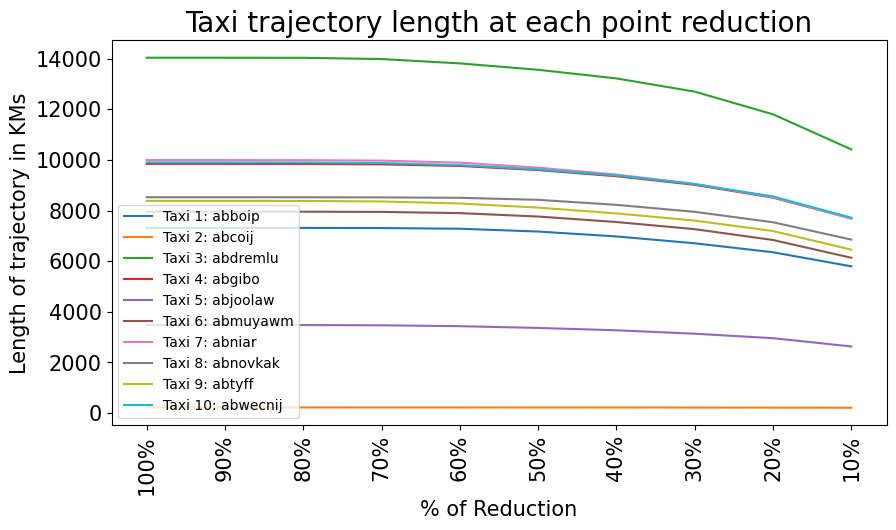

In [24]:
plt.figure(figsize = (10,5)) #creating the subplot grid

for i, taxi in enumerate(taxi_names):
    
    summed = list()
    dist_list = save_distances[taxi]
    
    for dist_array in dist_list:
        #computing the sum of all distance arrays besides the infinity (the first elements of each distance array)
        summed.append(np.sum(dist_array[1:])) 
    
    plt.plot(summed, label = f'Taxi {i+1}: {taxi}')
    
plt.title('Taxi trajectory length at each point reduction', fontsize=20)
plt.xticks(np.arange(0, 10), 
           [str(x)+'%' for x in range(100, 9, -10)], 
           fontsize=15, rotation=90)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(f'% of Reduction', fontsize=15)
plt.ylabel(f'Length of trajectory in KMs', fontsize=15)
plt.legend()
plt.show()

## Reducing the points with a random sample

Here the increase of average distance was expected, and the result is comparable to the one I got before, even though slightly more evident

_________________________________
Original Points: 23495
Original Points: 23495, Ratio of reduction: 90.00%, Remaining points: 21145
Original Points: 23495, Ratio of reduction: 80.00%, Remaining points: 18796
Original Points: 23495, Ratio of reduction: 70.00%, Remaining points: 16446
Original Points: 23495, Ratio of reduction: 60.00%, Remaining points: 14097
Original Points: 23495, Ratio of reduction: 50.00%, Remaining points: 11747
Original Points: 23495, Ratio of reduction: 40.00%, Remaining points: 9398
Original Points: 23495, Ratio of reduction: 30.00%, Remaining points: 7048
Original Points: 23495, Ratio of reduction: 20.00%, Remaining points: 4699
Original Points: 23495, Ratio of reduction: 10.00%, Remaining points: 2350
_________________________________
Original Points: 5454
Original Points: 5454, Ratio of reduction: 90.01%, Remaining points: 4909
Original Points: 5454, Ratio of reduction: 80.01%, Remaining points: 4364
Original Points: 5454, Ratio of reduction: 70.00%, Remainin

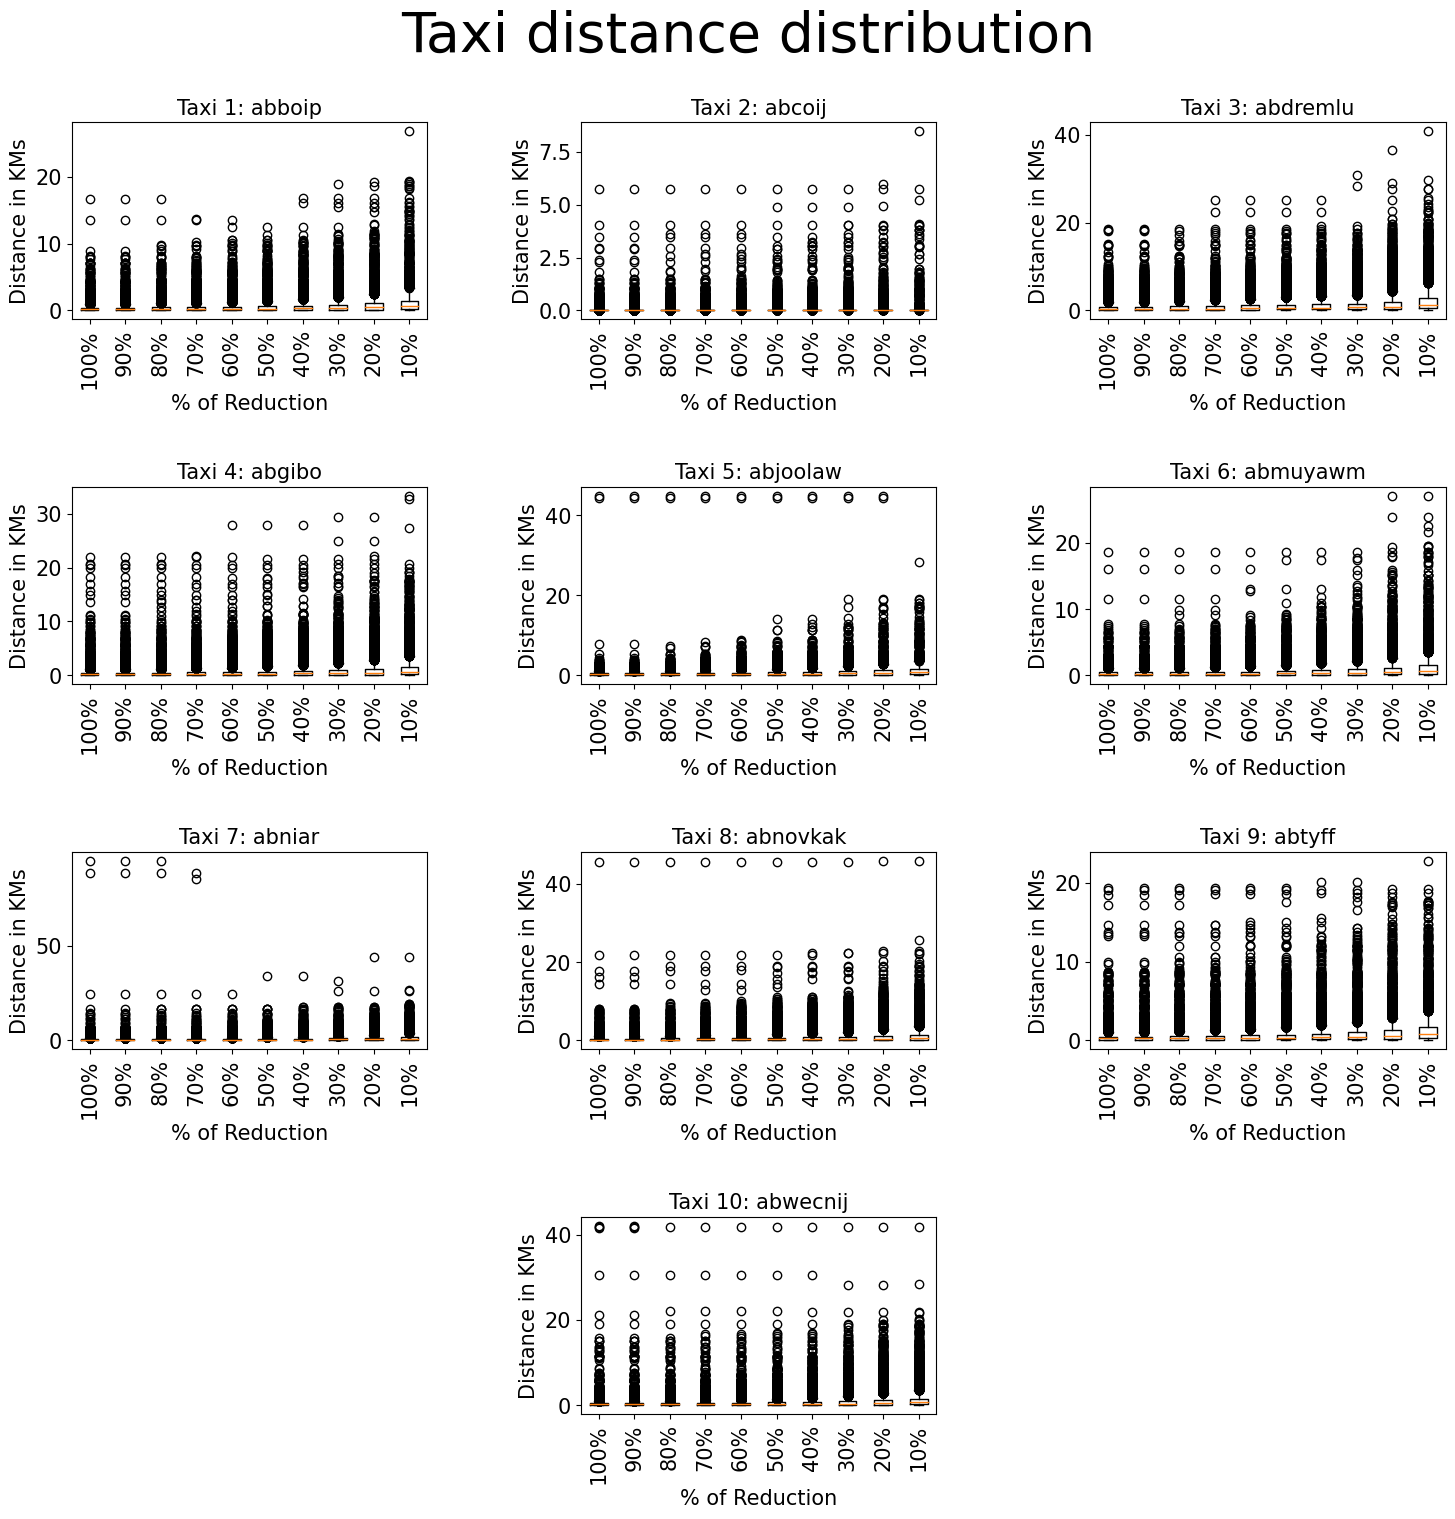

In [64]:
plt_rows, plt_columns = 4, 3 #setting 4 rows and 3 columns
fig, axs = plt.subplots(plt_rows, plt_columns, figsize = (15,15)) #creating the subplot grid
plt.suptitle('Taxi distance distribution', fontsize=40) #giving a title to the plot
fig.tight_layout(w_pad=8.0, h_pad=10.0, pad = 3.0) #adjusting the distances between plots

#arithmetic progression of percentiles to consider for each reduction
#I did it to reduce exactly the trajectory dataframe always by 10% of the original distribution
#otherwise the reduction of records would also reduce at each iteration

percentiles = [(x / (x-10)) for x in range(110, 10, -10)]

save_distances = dict()

for i, taxi in enumerate(taxi_names):
    print('_________________________________')
    
    single_taxi = user_tdf(tdf, taxi) #setting the tdf
    original_length = len(single_taxi) #storing the original length for computing the ratio later
    taxi_dist = [get_point_dists(single_taxi)] #adding the original distances to a new list
    
    print(f'Original Points: {original_length}')

    for reduction_n in range(9):
        distances = get_point_dists(single_taxi)
        taxi_dist.append(distances)
        
        #computing the percentile to consider at this iteration
        percentile = percentiles[reduction_n] - 1
        
        #reducing the records of the tdf according to a RANDOM SAMPLE
        single_taxi = single_taxi.sample(frac = 1 - percentile).sort_values(by='datetime', ascending = True) #sample and sort by datetime
        
        #getting the ratio of the reduced tdf according to the original length of the tdf
        ratio = len(single_taxi) / original_length
        print(f'Original Points: {original_length}, Ratio of reduction: {ratio:.2%}, Remaining points: {len(single_taxi)}')
        
    #saving the distribution of length of each taxi into a dictionary
    save_distances[taxi] = taxi_dist
    
    #### PLOT SETTINGS SHOWN BEFORE ####
    row_p = i // plt_columns
    col_p = i - plt_columns * row_p
    adjust_last = 1 if i == 9 else 0 

    current_ax = axs[row_p][col_p + adjust_last]
    
    current_ax.boxplot(taxi_dist)
    current_ax.set_xticks(np.arange(1, 11), 
                                    [str(x)+'%' for x in range(100, 9, -10)], 
                                    fontsize=15,
                                    rotation=90)

    current_ax.yaxis.set_tick_params(labelsize=15)
    current_ax.set_title(f'Taxi {i+1}: {taxi}', fontsize=15)
    current_ax.set_xlabel(f'% of Reduction', fontsize=15)
    current_ax.set_ylabel(f'Distance in KMs', fontsize=15)
    
#I am in the last row now, I remove the first and last columns of the subplot to leave only the one in the center
fig.delaxes(axs[row_p][col_p])
fig.delaxes(axs[row_p][col_p+2])
plt.show()

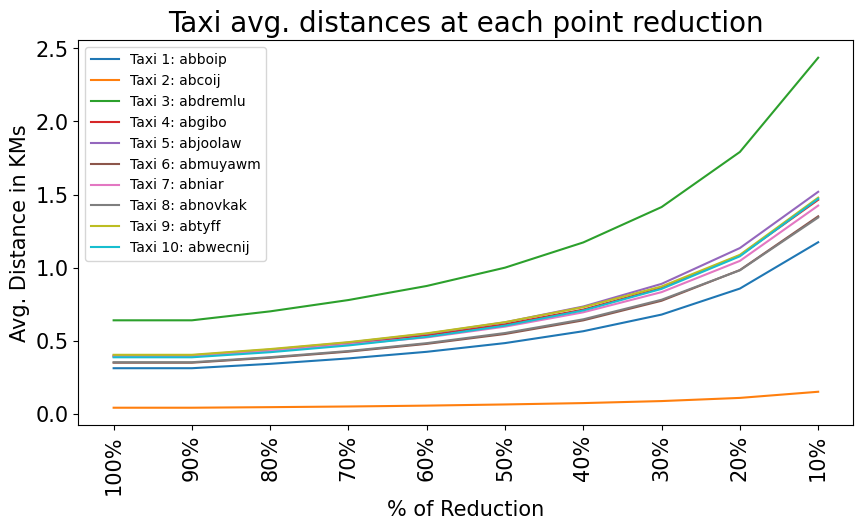

In [67]:
plt.figure(figsize = (10,5)) #creating the subplot grid

for i, taxi in enumerate(taxi_names):
    
    averages = list()
    dist_list = save_distances[taxi]
    
    for dist_array in dist_list:
        #computing the average of all distance arrays besides the infinity (the first elements of each distance array)
        averages.append(np.average(dist_array[1:])) 
    
    plt.plot(averages, label = f'Taxi {i+1}: {taxi}')
    
plt.title('Taxi avg. distances at each point reduction', fontsize=20)
plt.xticks(np.arange(0, 10), 
           [str(x)+'%' for x in range(100, 9, -10)], 
           fontsize=15, rotation=90)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(f'% of Reduction', fontsize=15)
plt.ylabel(f'Avg. Distance in KMs', fontsize=15)
plt.legend()
plt.show()

**As in the case of a removal of points close to each other, also in this case there is a slow reduction of the length of the Trajectories after each removal of points, probably for the same reason as before**

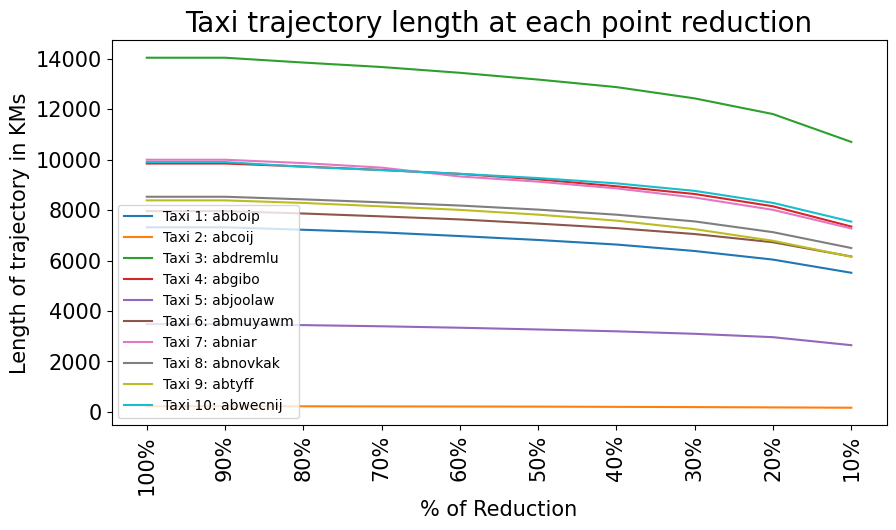

In [66]:
plt.figure(figsize = (10,5)) #creating the subplot grid

for i, taxi in enumerate(taxi_names):
    
    summed = list()
    dist_list = save_distances[taxi]
    
    for dist_array in dist_list:
        #computing the sum of all distance arrays besides the infinity (the first elements of each distance array)
        summed.append(np.sum(dist_array[1:])) 
    
    plt.plot(summed, label = f'Taxi {i+1}: {taxi}')
    
plt.title('Taxi trajectory length at each point reduction', fontsize=20)
plt.xticks(np.arange(0, 10), 
           [str(x)+'%' for x in range(100, 9, -10)], 
           fontsize=15, rotation=90)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(f'% of Reduction', fontsize=15)
plt.ylabel(f'Length of trajectory in KMs', fontsize=15)
plt.legend()
plt.show()

## Visualizing a trajectory after a random reduction of points

In [82]:
single_taxi = user_tdf(tdf, 'abdremlu')
sampled_taxi = single_taxi.sample(frac = 0.05).sort_values(by='datetime', ascending = True)

In [83]:
len(sampled_taxi) / len(single_taxi)

0.049995446680630176

I tried to see how much I would lose by exaggerating a bit (removing 95% of the distribution)

In [ ]:
map_f = folium.plugins.DualMap(location=(single_taxi['lat'].mean(), 
                                         single_taxi['lng'].mean()), 
                               tiles='cartodbpositron', zoom_start=12)

m1, m2 = map_f.m1, map_f.m2

single_taxi.plot_trajectory(map_f=m1, start_end_markers=False, hex_color='red', max_users=1, max_points=None)
sampled_taxi.plot_trajectory(map_f=m2, start_end_markers=False, hex_color='blue', max_users=1, max_points=None)

map_f

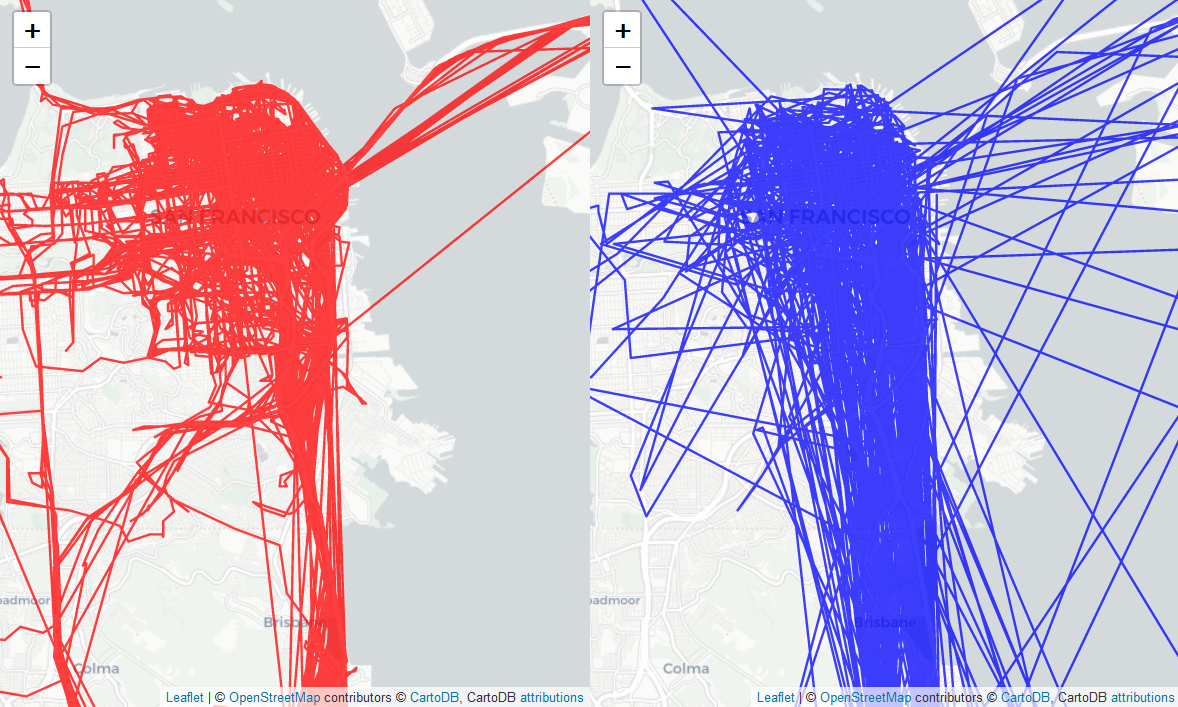